In [ ]:
!pip install -q transformers

In [ ]:
!cd LLaVA

/bin/bash: line 1: cd: LLaVA: No such file or directory


In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-aj74fkzp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-aj74fkzp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=53839078f948e701e51a9d3ae2310f09a98a9f7a30d9afb2835adcaace28010b
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7smqgll/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-23 05:02:40--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.106, 5

In [ ]:
!git clone https://github.com/haotian-liu/LLaVA.git
!cd LLaVA
!pip install -e .

fatal: destination path 'LLaVA' already exists and is not an empty directory.
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


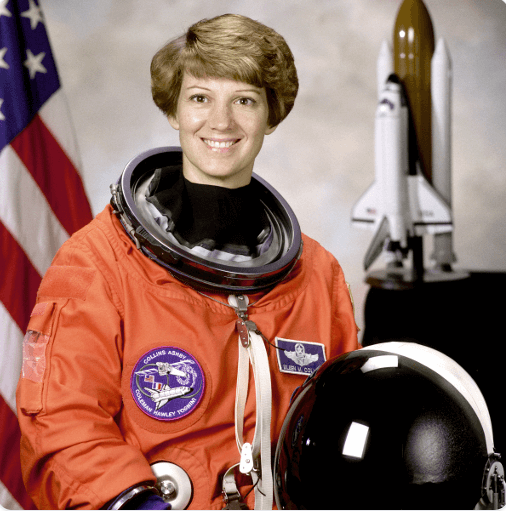

In [ ]:
from PIL import Image

im = Image.open("/content/astronaut.png")

im

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

sentence = "American flag, space suit, rocket, shuttle"
tokens = nltk.word_tokenize(sentence)

pos_tags = nltk.pos_tag(tokens)
nouns = [pos_tag[0] for pos_tag in pos_tags if pos_tag[1]=="NN"]

nouns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['flag', 'space', 'suit', 'rocket', 'shuttle']

In [ ]:
predictions = detector(im, candidate_labels=["person", "rocket", "space suit","flag", "space shuttle"],)
predictions

[{'score': 0.1474921703338623,
  'label': 'rocket',
  'box': {'xmin': 355, 'ymin': 64, 'xmax': 455, 'ymax': 284}},
 {'score': 0.14209163188934326,
  'label': 'person',
  'box': {'xmin': 16, 'ymin': 16, 'xmax': 363, 'ymax': 509}},
 {'score': 0.12109463661909103,
  'label': 'flag',
  'box': {'xmin': 0, 'ymin': 18, 'xmax': 96, 'ymax': 448}}]

In [ ]:
import numpy as np

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(im)

coord = []
labels = []

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    labels.append(label)

    xmin, ymin, xmax, ymax = box.values()
    coord.append(np.array([xmin, ymin, xmax, ymax]))
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")
coord

[array([355,  64, 455, 284]),
 array([ 16,  16, 363, 509]),
 array([  0,  18,  96, 448])]

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
image = cv2.imread('astronaut.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
# input_box = np.array([177, 71, 267, 175])
coord

In [ ]:
mask = []
for input_box in coord:
  masks, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=input_box[None, :],
      multimask_output=False,
  )
  mask.append(masks[0])

mask


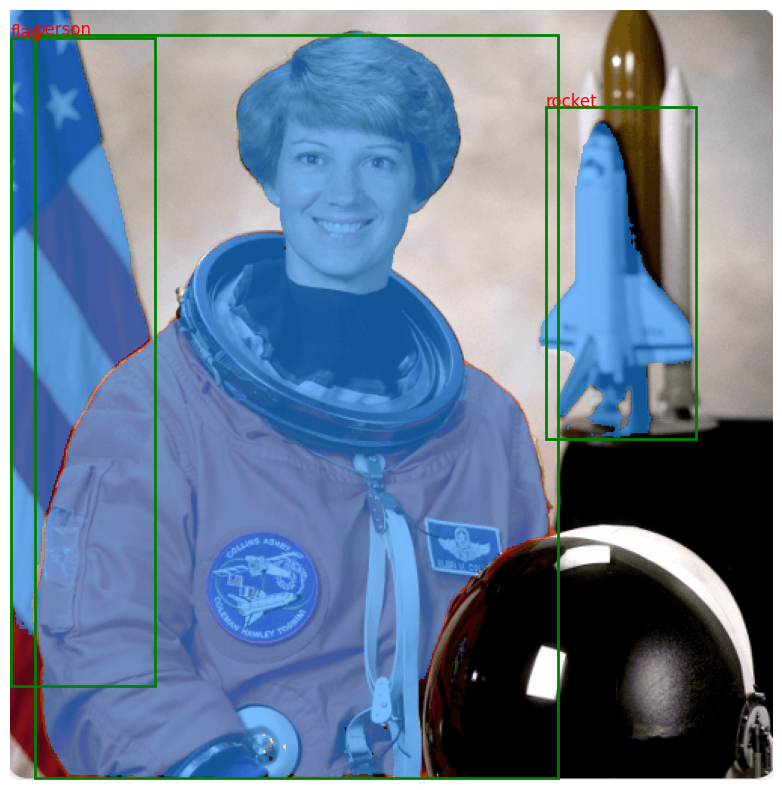

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for masks in mask:
  show_mask(masks, plt.gca())

i=0
for input_box in coord:
  show_box(input_box, plt.gca())
  plt.text(input_box[0], input_box[1], labels[i], fontsize=12, color='red')
  i+=1

plt.axis('off')
plt.show()